In [1]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 16.7 MB/s eta 0:00:0000:01


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.17.1
KerasNLP version: 0.19.1


In [3]:
# Ensure stopwords are downloaded
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df_train = pd.read_csv("/kaggle/input/natural-language-processing-with-disaster-tweets/train.csv")
df_test = pd.read_csv("/kaggle/input/natural-language-processing-with-disaster-tweets/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [8]:
# Define preprocessing functions
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop])


In [9]:
# Apply preprocessing to train and test datasets
df_train['text_clean'] = df_train['text'].apply(lambda x: remove_URL(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: remove_emoji(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: remove_html(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: remove_punct(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: x.lower())  # Lowercasing
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: remove_stopwords(x))

df_test['text_clean'] = df_test['text'].apply(lambda x: remove_URL(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: remove_emoji(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: remove_html(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: remove_punct(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: x.lower())  # Lowercasing
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: remove_stopwords(x))

# Display sample cleaned text
print(df_train[['text', 'text_clean']].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          text_clean  
0       deeds reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  residents asked shelter place notified officer...  
3  13000 people receive wildfires evacuation orde...  
4  got sent photo ruby alaska smoke wildfires pou...  


In [17]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 4
AUTO = tf.data.experimental.AUTOTUNE

In [11]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [12]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
import tensorflow as tf

classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"]
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 100s 361ms/step - accuracy: 0.8990 - loss: 0.2710 - val_accuracy: 0.8365 - val_loss: 0.4111
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 46s 242ms/step - accuracy: 0.9190 - loss: 0.2334 - val_accuracy: 0.8398 - val_loss: 0.4278
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 46s 242ms/step - accuracy: 0.9309 - loss: 0.1999 - val_accuracy: 0.8286 - val_loss: 0.4576
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 46s 242ms/step - accuracy: 0.9400 - loss: 0.1726 - val_accuracy: 0.8253 - val_loss: 0.4996


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def displayConfusionMatrix(y_true, y_pred, dataset):
    # Convert y_pred probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Calculate Precision, Recall, and F1-score
    precision = precision_score(y_true, y_pred_labels)
    recall = recall_score(y_true, y_pred_labels)
    f1 = f1_score(y_true, y_pred_labels)

    # Print the performance metrics
    print(f"\nPerformance Metrics on {dataset} Dataset:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

    # Display confusion matrix
    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(cm, display_labels=["Not Disaster", "Disaster"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix ({dataset})")
    plt.show()  # Show the first plot

    # Sentence break before showing the next graph
    print("\nNormalized Confusion Matrix:")

    # Display normalized confusion matrix
    disp_norm = ConfusionMatrixDisplay(cm_normalized, display_labels=["Not Disaster", "Disaster"])
    disp_norm.plot(cmap=plt.cm.Blues)
    plt.title(f"Normalized Confusion Matrix ({dataset})")
    plt.show()  # Show the second plot


191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step

Performance Metrics on Training Dataset:
Precision: 0.9921
Recall: 0.9119
F1 Score: 0.9503

Confusion Matrix:


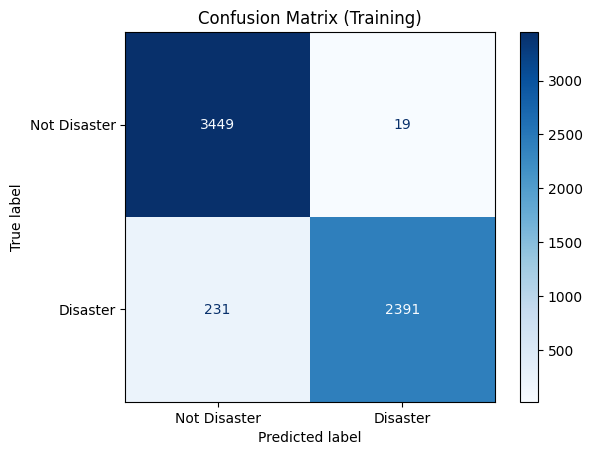


Normalized Confusion Matrix:


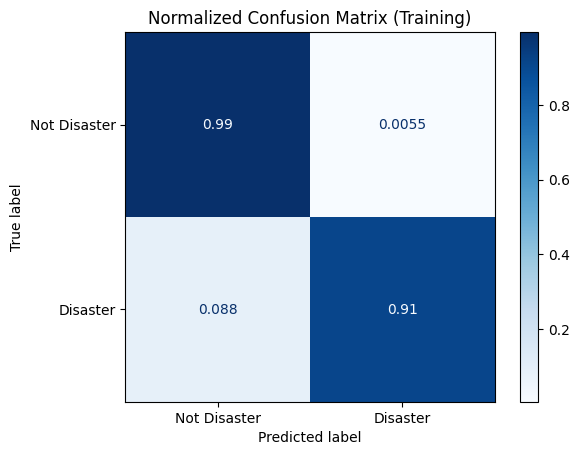

In [20]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step

Performance Metrics on Validation Dataset:
Precision: 0.8262
Recall: 0.7473
F1 Score: 0.7848

Confusion Matrix:


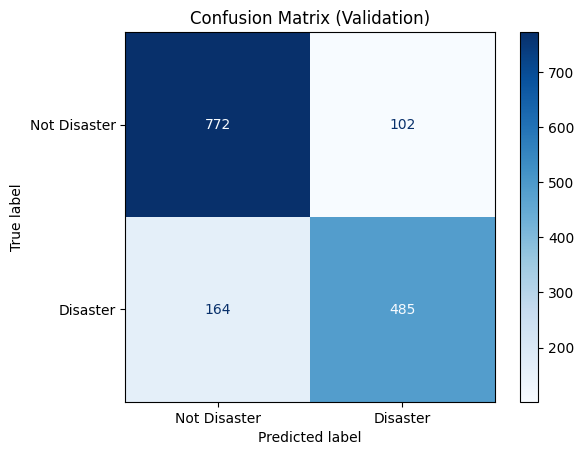


Normalized Confusion Matrix:


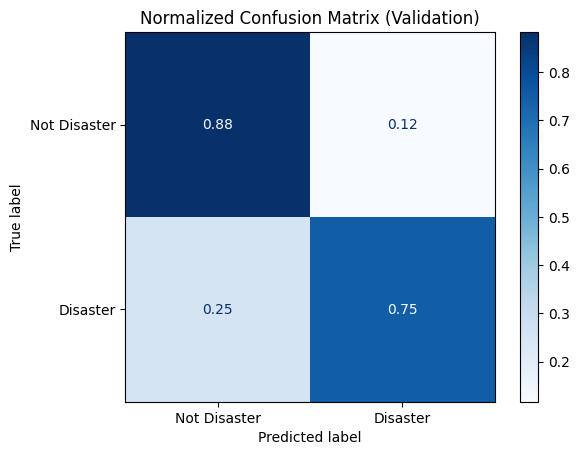

In [21]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")